# Image Identification: Frogs in Massachusetts

This project uses a neural network model to identify frog species from images. 
**Demo**
View the app in action here: https://huggingface.co/spaces/kaysrubio/Identifying_Frogs_in_Massachusetts

**Steps:**
1. Searched Duck Duck Go using their API to find 200 pictures of the 10 species of frogs in Massachusetts
2. Used those pictures to fine tune resnet18, a pretrained image model
3. Used model results to identify outliers. 
4. Tested this frog-identification model on a frog picture and evaluated it's accuracy
5. Exported model for future use

**Findings:** Final model trained on 200 pictures had 27% error rate.

**Model Training Details:**
Model error rate improved from 40% to 34% when I shifted from 100 to 200 photos per frog species.
Model error rate further improved from 34% to 27% when I used RandomResizedCrop rather than squish on the data each epoch.
Final model only needed 2 epoch's to train. Epochs 3-4 showed overfitting as training loss decreased but validation loss didn't and error rate slightly increased.

**Next steps:**
To improve this model, it would be helpful to clean the training data. Delete images of tadpoles and the occasional icon, as well as ask a frog expert to see if any are mis-labelled.

Date last updated: 2/5/2025</br>
Author: Kay Rubio</br>
Environment created in: Kaggle Notebooks</br>
Note: to run this notebook, make sure your notebook environment has internet access

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai 'duckduckgo_search>=6.2'
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 53.0 MB/s eta 0:00:00:00:01


In [6]:
import time, json
from duckduckgo_search import DDGS
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
import re
# from fastai.vision.widgets import *

In [2]:
# Define function that will use duck duck go to search the internet for images based on a keyword
def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

In [3]:
# List of 10 frog species in Massachusetts from https://www.massaudubon.org/nature-wildlife/reptiles-amphibians/frogs
frogs = ['American Bullfrog (Lithobates catesbeianus)', 'American Toad (Anaxyrus americanus)', 'Eastern Spadefoot (Scaphiopus holbrookii)', 'Fowlers Toad (Anaxyrus fowleri)', 'Gray Treefrog (Hyla versicolor)', 'Green Frog (Lithobates clamitans)', 'Northern Leopard Frog (Lithobates pipiens)', 'Pickerel Frog (Lithobates palustris)', 'Spring Peeper (Pseudacris crucifer)', 'Wood Frog (Lithobates sylvaticus)']

In [7]:
# Defining a folder name to use in kaggle/working directory
path = Path('frog_type')

In [8]:
# Number of photos per category to collect from duck duck go
NUM_OF_PHOTOS = 200
# for loop will iterate over each type of frog, and save 200 pics of each frog in a folder
for i, frog in enumerate(frogs):
    # Make simpler folder names without species or spaces
    folder_name = re.sub(r"\(.*?\)", "", frogs[i]).strip().replace(' ', '_')
    dest = (path/folder_name)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{frog} photo', NUM_OF_PHOTOS))
    time.sleep(5)
    resize_images(path/folder_name, max_size=400, dest=path/folder_name)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
# Shell commands to clear dataset if you need to re-collect data or fix folder names
#!pwd
#!cd frog_type
#!rm -r frog_type
#!ls

In [9]:
# use verify_images method to find out which images didn’t have good paths and remove them
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

16

In [10]:
# Create a DataBlock instance
# DataBlock is a data structure from fastai that helps get the data for all kinds of 
# projects into the right shape including test/train split, and x, y
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='RandomResizedCrop')] # resize in different ways each epoch for a little data augmentation
).dataloaders(path, bs=32)

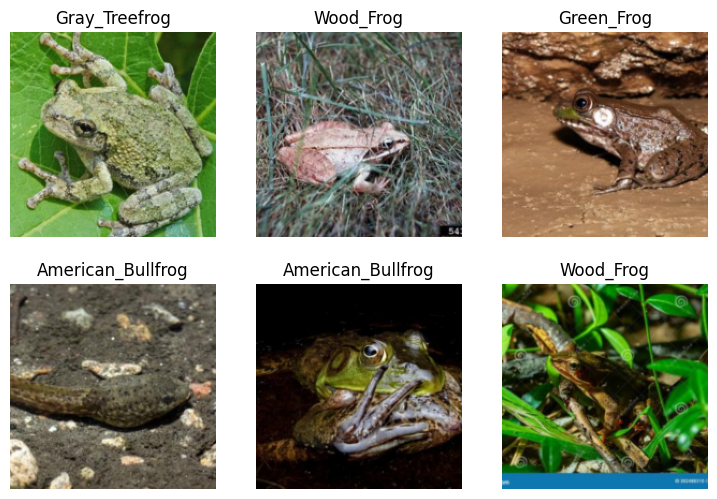

In [11]:
# Look at some of the images in the DataBlock instance
dls.show_batch(max_n=6)

In [12]:
# Train model using pre-trained computer vision model resnet18
learn = vision_learner(dls, resnet18, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


In [ ]:
# Optional - learn some information about this method
# doc(learn.fine_tune)

In [13]:
# fine_tune the model on this dataset
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.492803,1.097246,0.391892,01:47


epoch,train_loss,valid_loss,error_rate,time
0,1.136097,0.867143,0.297297,02:36
1,0.898338,0.879897,0.267568,02:34
2,0.568680,0.858726,0.286486,02:34
3,0.384788,0.824670,0.270270,02:37


In [ ]:
# Train 1: Used 100 pics per frog, and only 3 training epochs, but got an 
# the error_rate of 40%, so that's not very good

# Train 2: Used 200 pics per frog, squished each pic, and used 4 training epochs
# and got an error rate of 34% that stayed pretty constant from epoch 3-4. 

# Train 3: Used 200 pics per frog, used RandomResizedCrop to vary how images 
# cut down, and got a much better error rate of 27%. Seems like the error rate was
# lowest in first epoch, but then it started to overfit, and corrected itself

# Epochs took ~3-4 min each on Kaggle GPU

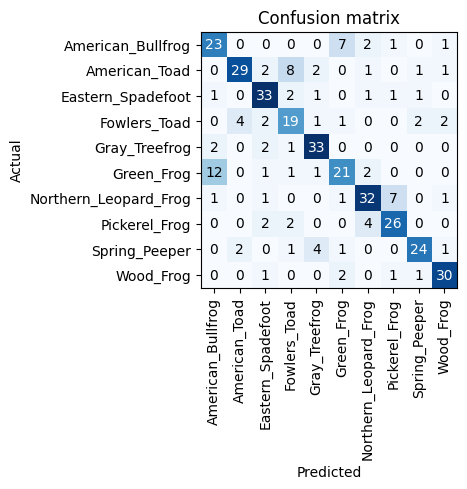

In [14]:
# Plot confusion matrix to see which frog species are getting mixed up
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Looks like there's a few problems above:
- American Bullfrog and Green Frog
- American Toad and Fowlers Toad
- Northern Leopard Frog and Pickerel Frog

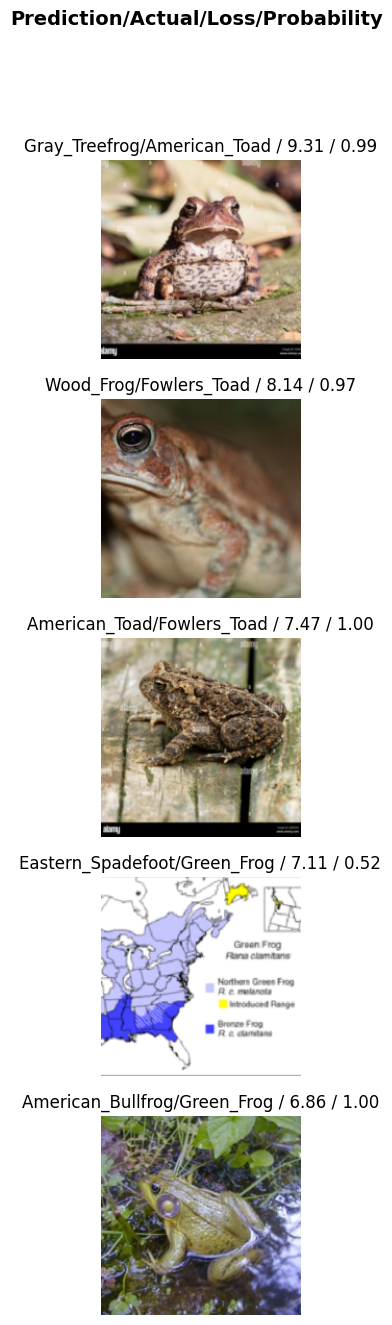

In [46]:
# Plot images in the data that have top loss, like model was incorrect but had 
# high confidence, OR model was correct but had low confidence
interp.plot_top_losses(5, nrows=5)

Ideally I'd use this to delete images that aren't photos, but there's no filename?

## Data Cleaning

In [ ]:
# Use ImageClassifierCleaner GUI from fastai to manually check images with highest 
# loss, either due to incorrect classification, or correct classification with low
# confidence. This helps quickly find outliers
# cleaner = ImageClassifierCleaner(learn)
# cleaner

In [ ]:
# Delete images --> if cleaner was working, this is what I'd run
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [ ]:
# Relabel images --> if cleaner was working, this is what I'd run
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
# re-fine_tune the model on cleaner dataset
# learn.fine_tune(4)

I tried the ImageClassifierCleaner fastai tool, but didn't not find it to work. I don't think it was saving my selections, and when I tried to run the deletion, it actually crashed my notebook (cell wouldn't stop running, and even keyboard interrupt code didn't work, so I had to clear all cell output and start over). With some googling, found ample complaints online, so while this is a great idea, not sure if fastai has gotten this tool working yet, especially with many categories. 

## Make an inference with the model

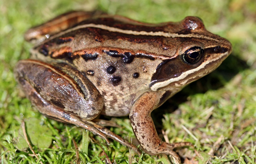

In [17]:
# Use Duck Duck Go to find a random picture of a Wood Frog to use as input to test the model
urls = search_images('Wood Frog', max_images=1)
urls[0]
dest = 'frog1.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256,256)

In [26]:
# Use the model to identify a frog pic
species,index,probs = learn.predict(PILImage.create('frog1.jpg'))
# print(f"There is a {probs[index]:.4f} probability that this is a {species}")
print(f"There is a {probs[index] * 100:.2f}% chance that this is a {frogs[index]}")
print("\nOther possibilities include:")
for i,frog_type in enumerate(frogs):
    print(f" - {frog_type}: {probs[i] * 100:.4f}%")

There is a 93.24% chance that this is a Wood Frog (Lithobates sylvaticus)

Other possibilities include:
 - American Bullfrog (Lithobates catesbeianus): 0.0099%
 - American Toad (Anaxyrus americanus): 0.0261%
 - Eastern Spadefoot (Scaphiopus holbrookii): 0.0500%
 - Fowlers Toad (Anaxyrus fowleri): 0.1425%
 - Gray Treefrog (Hyla versicolor): 0.0122%
 - Green Frog (Lithobates clamitans): 5.2597%
 - Northern Leopard Frog (Lithobates pipiens): 0.9412%
 - Pickerel Frog (Lithobates palustris): 0.1598%
 - Spring Peeper (Pseudacris crucifer): 0.1598%
 - Wood Frog (Lithobates sylvaticus): 93.2388%


In [ ]:
# Correctly identified this frog pic! And it was pretty confident

## Export Model

In [27]:
# Export the trained model (incl. model architecture, trained weights, 
# and data loader info) for future use
learn.export()

In [29]:
#!pwd
#!cd frog_type
#!rm -r frog_type
!ls

export.pkl  frog1.jpg  frog_type


In [30]:
# Kaggle Output foler is giving me the spinning wheel and not loading, so download it more manually
%cd /kaggle/working

/kaggle/working


In [32]:
from IPython.display import FileLink
FileLink(r'export.pkl')

/kaggle/working/export.pkl

## Import model and make sure it works

In [45]:
import os;

In [42]:
# Kaggle stuck it in many subfolders (which aren't seen in the GUI)
print(os.listdir('/kaggle/input/copy/pytorch/default/1'))

['copy.pkl']


In [43]:
learn_inf = load_learner('/kaggle/input/copy/pytorch/default/1/copy.pkl')

In [44]:
# Looks like its working!
learn_inf.predict(PILImage.create('frog1.jpg'))

('Wood_Frog',
 tensor(9),
 tensor([9.9230e-05, 2.6081e-04, 5.0003e-04, 1.4249e-03, 1.2234e-04, 5.2597e-02,
         9.4121e-03, 1.5978e-03, 1.5976e-03, 9.3239e-01]))